
# PET TOF listmode projector

In this example we will show how to setup and use a TOF 
PET listmode projector including geometrical forward projection
in listmode, image-based resolution model and a listmode 
attenuation model.

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [22]:
import array_api_compat.numpy as xp

# import array_api_compat.cupy as xp
# import array_api_compat.torch as xp

In [45]:
import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
import sys

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    dev = "cuda"

## Setup a small regular polygon PET scanner with 5 rings (polygons)



In [24]:
num_rings = 4
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=65.0,
    num_sides=12,
    num_lor_endpoints_per_side=15,
    lor_spacing=2.3,
    ring_positions=xp.linspace(-10, 10, num_rings),
    symmetry_axis=1,
)

## Generate 4 arbitrary listmode events



In [25]:
start_ring = xp.asarray([2, 1, 0, 3], device=dev)
start_xtal = xp.asarray([0, 59, 143, 75], device=dev)

end_ring = xp.asarray([2, 0, 1, 3], device=dev)
end_xtal = xp.asarray([79, 140, 33, 147], device=dev)

event_start_coordinates = scanner.get_lor_endpoints(start_ring, start_xtal)
event_end_coordinates = scanner.get_lor_endpoints(end_ring, end_xtal)

print(event_start_coordinates)
print(event_end_coordinates)

# setup TOF parameters with a TOF resolution FWHM = 30mm (ca 200ps)
tof_params = parallelproj.TOFParameters(
    sigma_tof=30.0 / 2.35, num_tofbins=59, tofbin_width=12.5
)
event_tof_bins = xp.asarray([0, 1, 0, -1], device=dev)

[[ 65.          3.3333333 -16.1      ]
 [-16.100002   -3.3333333  65.       ]
 [  2.3000007 -10.        -65.       ]
 [-48.24166    10.         46.443    ]]
[[-52.84166     3.3333333  38.475563 ]
 [ -4.599999  -10.        -65.       ]
 [ 40.46743    -3.3333333  51.691654 ]
 [ 11.500001   10.        -65.       ]]


## Show the scanner geometry and the events



C:\Users\holot\AppData\Local\Temp\ipykernel_2184\2911726249.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


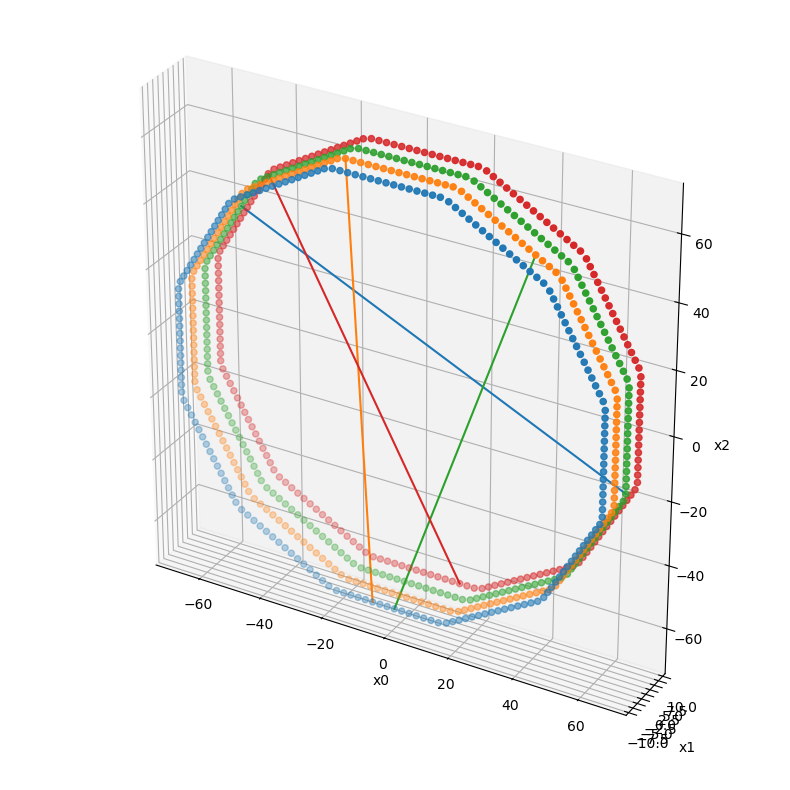

In [26]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
scanner.show_lor_endpoints(ax)
for i in range(event_start_coordinates.shape[0]):
    ax.plot(
        [float(event_start_coordinates[i, 0]), float(event_end_coordinates[i, 0])],
        [float(event_start_coordinates[i, 1]), float(event_end_coordinates[i, 1])],
        [float(event_start_coordinates[i, 2]), float(event_end_coordinates[i, 2])],
    )
fig.tight_layout()
fig.show()

## Setup a TOF listmode projector and a test image



In [51]:
img_shape = (40, 9, 40)
voxel_size = (2.0, 3.0, 2.0)

lm_proj = parallelproj.ListmodePETProjector(
    event_start_coordinates, event_end_coordinates, img_shape, voxel_size
)

# set the TOF parameters
lm_proj.tof_parameters = tof_params
# set the event TOF bins
lm_proj.event_tofbins = event_tof_bins
# enable TOF
lm_proj.tof = True

x = xp.ones(img_shape, dtype=xp.float32, device=dev)

print(lm_proj)

print(sys.getsizeof(lm_proj.event_tofbins))
print(sys.getsizeof(lm_proj.tof_parameters))

128
56


## Perform listmode forward and back projections



In [43]:
%%timeit -n 1
x_fwd = lm_proj(x)
print(x_fwd)

# back project a list of ones
ones_list = xp.ones(lm_proj.num_events, dtype=xp.float32, device=dev)
y_back = lm_proj.adjoint(ones_list)

[12.453875  12.250091  12.4283695 12.409251 ]
[12.453875  12.250091  12.4283695 12.409251 ]
[12.453875  12.250091  12.4283695 12.409251 ]
[12.453875  12.250091  12.4283695 12.409251 ]
[12.453875  12.250091  12.4283695 12.409251 ]
[12.453875  12.250091  12.4283695 12.409251 ]
[12.453875  12.250091  12.4283695 12.409251 ]
3.62 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Show the backprojected list of ones (events)



C:\Users\holot\AppData\Local\Temp\ipykernel_2184\670766297.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


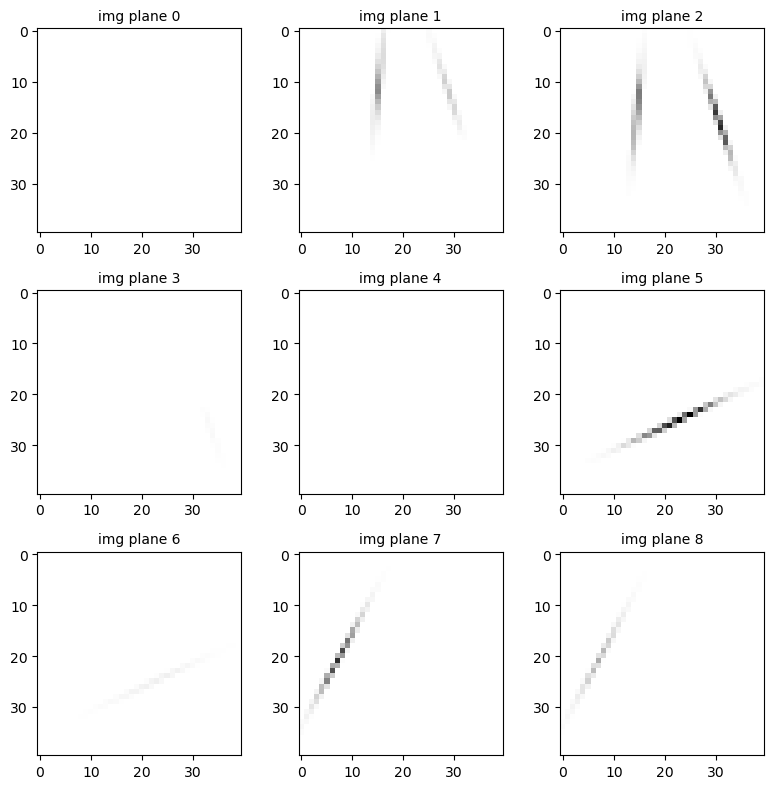

In [29]:
fig2, ax2 = plt.subplots(3, 3, figsize=(8, 8))
vmax = float(xp.max(y_back))
for i in range(ax2.size):
    if i < y_back.shape[1]:
        axx = ax2.ravel()[i]
        axx.imshow(
            parallelproj.to_numpy_array(y_back[:, i, :].T),
            cmap="Greys",
            vmin=0,
            vmax=vmax,
        )
        axx.set_title(f"img plane {i}", fontsize="medium")
    else:
        ax2.ravel()[i].set_axis_off()
fig2.tight_layout()
fig2.show()

## Combine the listmode projector with a resolution and attenuation model



In [30]:
# setup a simple image-based resolution model with an Gaussian FWHM of 4.5mm
res_model = parallelproj.GaussianFilterOperator(
    lm_proj.in_shape, sigma=4.5 / (2.35 * lm_proj.voxel_size)
)

# define arbritrary attenuation factors
att_list = xp.asarray([0.3, 0.4, 0.2, 0.6], device=dev)
att_op = parallelproj.ElementwiseMultiplicationOperator(att_list)


lm_proj_with_res_model_and_att = parallelproj.CompositeLinearOperator(
    (att_op, lm_proj, res_model)
)

x_fwd2 = lm_proj_with_res_model_and_att(x)
print(x_fwd2)

y_back2 = lm_proj_with_res_model_and_att.adjoint(ones_list)

[3.73616238 4.90003624 2.4856739  7.44555073]


## Show the backprojected list of ones (events)



C:\Users\holot\AppData\Local\Temp\ipykernel_2184\1582806590.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


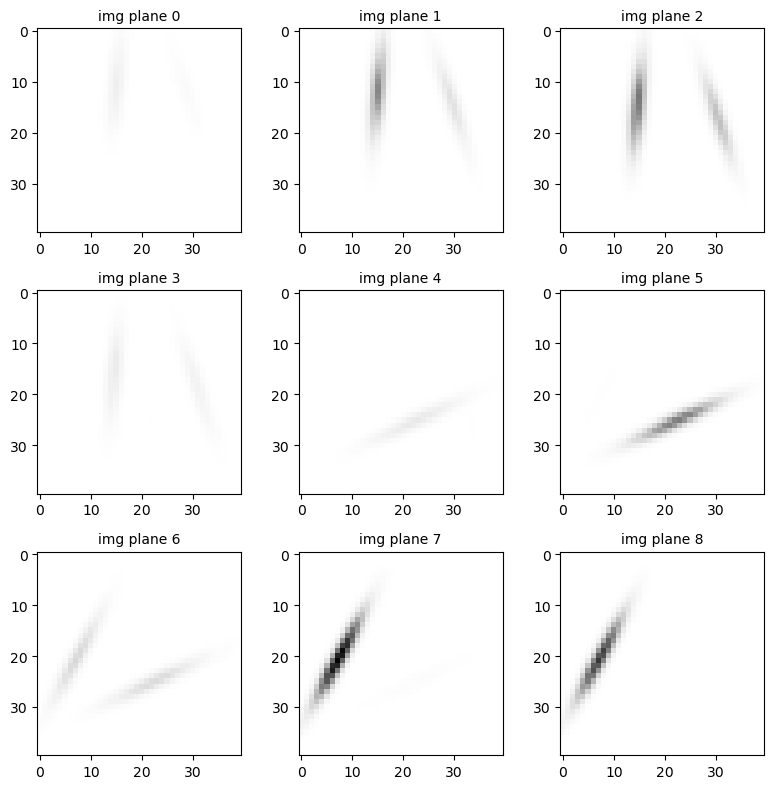

In [31]:
fig3, ax3 = plt.subplots(3, 3, figsize=(8, 8))
vmax = float(xp.max(y_back2))
for i in range(ax3.size):
    if i < y_back.shape[1]:
        axx = ax3.ravel()[i]
        axx.imshow(
            parallelproj.to_numpy_array(y_back2[:, i, :].T),
            cmap="Greys",
            vmin=0,
            vmax=vmax,
        )
        axx.set_title(f"img plane {i}", fontsize="medium")
    else:
        ax3.ravel()[i].set_axis_off()
fig3.tight_layout()
fig3.show()